In [1]:
# Imports
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np

from tiingo import TiingoClient
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import math
from numpy import array
from sklearn.metrics import mean_squared_error

In [2]:
# Get RealTime data

config = {}
config['session'] = True
config['api_key'] = "fde0de34a597024753ba4740d038106ed7b2f556"

client = TiingoClient(config)

In [3]:
# Accesing desired data

dataset = client.get_ticker_metadata("AAPl")

df = pdr.get_data_tiingo('AAPL',api_key='fde0de34a597024753ba4740d038106ed7b2f556')

/home/spielerin/.local/lib/python3.8/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [4]:
data = df.to_csv('AAPL.csv')
df=pd.read_csv('AAPL.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-01-06 00:00:00+00:00,117.91,118.16,116.47,116.780,31751900,27.743303,27.802126,27.404482,27.477423,127007600,0.0,1.0
1,AAPL,2017-01-09 00:00:00+00:00,118.99,119.43,117.94,117.950,33561948,27.997418,28.100947,27.750362,27.752715,134247792,0.0,1.0
2,AAPL,2017-01-10 00:00:00+00:00,119.11,119.38,118.30,118.770,24462051,28.025654,28.089182,27.835067,27.945654,97848204,0.0,1.0
3,AAPL,2017-01-11 00:00:00+00:00,119.75,119.93,118.60,118.740,27588593,28.176241,28.218593,27.905655,27.938595,110354372,0.0,1.0
4,AAPL,2017-01-12 00:00:00+00:00,119.25,119.30,118.21,118.895,27086220,28.058594,28.070359,27.813891,27.975066,108344880,0.0,1.0


In [5]:
df.shape

(1258, 14)

In [6]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2021-12-29 00:00:00+00:00,179.38,180.63,178.14,179.330,62348931,179.38,180.63,178.14,179.330,62348931,0.0,1.0
1254,AAPL,2021-12-30 00:00:00+00:00,178.20,180.57,178.09,179.470,59773014,178.20,180.57,178.09,179.470,59773014,0.0,1.0
1255,AAPL,2021-12-31 00:00:00+00:00,177.57,179.23,177.26,178.085,61661433,177.57,179.23,177.26,178.085,61661433,0.0,1.0
1256,AAPL,2022-01-03 00:00:00+00:00,182.01,182.88,177.71,177.830,104701220,182.01,182.88,177.71,177.830,104701220,0.0,1.0
1257,AAPL,2022-01-04 00:00:00+00:00,179.70,182.94,179.12,182.630,99310438,179.70,182.94,179.12,182.630,99310438,0.0,1.0


In [7]:
df1 = df.reset_index()['close']
df1.shape

(1258,)

In [8]:
df1

0       117.91
1       118.99
2       119.11
3       119.75
4       119.25
         ...  
1253    179.38
1254    178.20
1255    177.57
1256    182.01
1257    179.70
Name: close, Length: 1258, dtype: float64

In [9]:
df1[1228:]

1228    161.02
1229    161.41
1230    161.94
1231    156.81
1232    160.24
1233    165.30
1234    164.77
1235    163.76
1236    161.84
1237    165.32
1238    171.18
1239    175.08
1240    174.56
1241    179.45
1242    175.74
1243    174.33
1244    179.30
1245    172.26
1246    171.14
1247    169.75
1248    172.99
1249    175.64
1250    176.28
1251    180.33
1252    179.29
1253    179.38
1254    178.20
1255    177.57
1256    182.01
1257    179.70
Name: close, dtype: float64

In [10]:
df1.shape

(1258,)

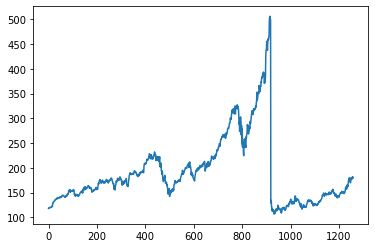

In [11]:
plt.plot(df1)

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
df1

array([[0.02772699],
       [0.03043206],
       [0.03073262],
       ...,
       [0.17715717],
       [0.18827802],
       [0.18249217]])

In [14]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:1],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(817, 441)

In [16]:
train_data
print(type(train_data))

<class 'numpy.ndarray'>


In [17]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(716, 100) (716,) (340, 100) (340,)


In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 186ms/step - loss: 0.0179 - val_loss: 0.0108
Epoch 2/100
12/12 [==============================] - 1s 105ms/step - loss: 0.0037 - val_loss: 0.0230
Epoch 3/100
12/12 [==============================] - 1s 99ms/step - loss: 0.0019 - val_loss: 0.0184
Epoch 4/100
12/12 [==============================] - 1s 85ms/step - loss: 9.7635e-04 - val_loss: 0.0207
Epoch 5/100
12/12 [==============================] - 1s 89ms/step - loss: 9.1922e-04 - val_loss: 0.0201
Epoch 6/100
12/12 [==============================] - 1s 85ms/step - loss: 8.8882e-04 - val_loss: 0.0193
Epoch 7/100
12/12 [==============================] - 1s 88ms/step - loss: 7.9554e-04 - val_loss: 0.0215
Epoch 8/100
12/12 [==============================] - 1s 86ms/step - loss: 8.1560e-04 - val_loss: 0.0189
Epoch 9/100
12/12 [==============================] - 1s 119ms/step - loss: 7.0910e-04 - val_loss: 0.0177
Epoch 10/100
12/12 [==============================] - 1s 111ms/step - los

In [25]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [26]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [27]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(Y_train,train_predict))

201.34228661687416

In [28]:
### Test Data RMSE
math.sqrt(mean_squared_error(Y_test,test_predict))

144.01072449940173

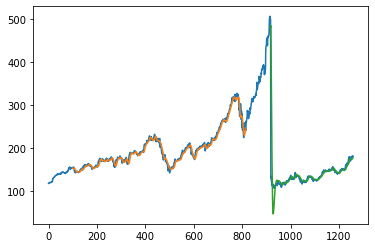

In [29]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [30]:
len(test_data)

441

In [31]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 101)

In [32]:
x_input

array([[0.10532248, 0.10584847, 0.11090795, 0.10857858, 0.0989856 ,
        0.09983719, 0.10356919, 0.10737633, 0.10715091, 0.10399499,
        0.10194114, 0.10459612, 0.11591735, 0.11268629, 0.11438948,
        0.11724483, 0.11887289, 0.12485911, 0.12090169, 0.11829681,
        0.10552286, 0.10697558, 0.10339386, 0.10567314, 0.10507201,
        0.09823419, 0.09041954, 0.09164684, 0.0977082 , 0.10016281,
        0.10038823, 0.09650595, 0.0878397 , 0.09014402, 0.08681277,
        0.08969317, 0.08090169, 0.08583594, 0.08806512, 0.09129618,
        0.09031935, 0.09009393, 0.08683782, 0.085335  , 0.09247339,
        0.09517846, 0.09946149, 0.10499687, 0.10624922, 0.10680025,
        0.10482154, 0.10469631, 0.1063995 , 0.10522229, 0.11453976,
        0.10760175, 0.10549781, 0.10815279, 0.11183469, 0.1105072 ,
        0.1113087 , 0.10920476, 0.1101315 , 0.10289292, 0.10276769,
        0.10807765, 0.10810269, 0.11060739, 0.11684408, 0.12781465,
        0.13452724, 0.13570445, 0.13668128, 0.13

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
# demonstrate prediction for next 30 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.10584847 0.11090795 0.10857858 0.0989856  0.09983719 0.10356919
 0.10737633 0.10715091 0.10399499 0.10194114 0.10459612 0.11591735
 0.11268629 0.11438948 0.11724483 0.11887289 0.12485911 0.12090169
 0.11829681 0.10552286 0.10697558 0.10339386 0.10567314 0.10507201
 0.09823419 0.09041954 0.09164684 0.0977082  0.10016281 0.10038823
 0.09650595 0.0878397  0.09014402 0.08681277 0.08969317 0.08090169
 0.08583594 0.08806512 0.09129618 0.09031935 0.09009393 0.08683782
 0.085335   0.09247339 0.09517846 0.09946149 0.10499687 0.10624922
 0.10680025 0.10482154 0.10469631 0.1063995  0.10522229 0.11453976
 0.10760175 0.10549781 0.10815279 0.11183469 0.1105072  0.1113087
 0.10920476 0.1101315  0.10289292 0.10276769 0.10807765 0.10810269
 0.11060739 0.11684408 0.12781465 0.13452724 0.13570445 0.13668128
 0.13800877 0.12515967 0.13375078 0.14642455 0.14509706 0.14256731
 0.1377583  0.14647464 0.16115216 0.17092048 0.16961803 0.181866
 0.17257358 0.16904195 0.18149029 0.16385723 0.161051

In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [36]:
len(df1)

1258

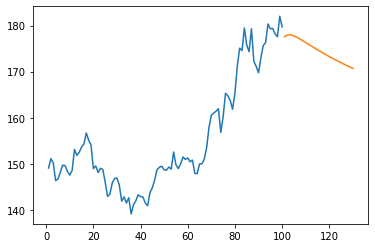

In [38]:
# Closing price of next 30 days
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

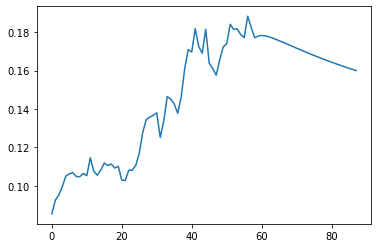

In [39]:
# Training + Testing Closing Prices
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [40]:
df3=scaler.inverse_transform(df3).tolist()

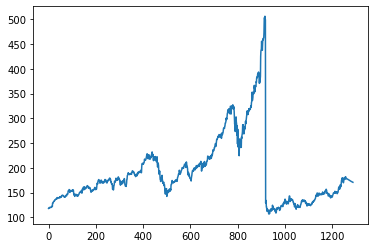

In [41]:
plt.plot(df3)